<a href="https://colab.research.google.com/github/sharathchandran2001/GeneralUtils/blob/main/1_Shor_RSA21_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔐 Simulated Shor's Algorithm: Factoring a Small RSA-like Key (N = 21)

This notebook demonstrates how to use PennyLane to simulate Shor's algorithm and factor a small RSA-style number **N = 21 (3 × 7)**.

We simulate the quantum process of period finding and use classical post-processing to extract the original prime factors.

In [ ]:
!pip install pennylane numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 97.1 MB/s eta 0:00:00


In [ ]:
# Re-import libraries and redefine the complete program after code execution reset
import pennylane as qml
import numpy as np
from fractions import Fraction
from math import gcd
import time
import random

# -------------------------------------
# Utility: Post-processing to extract factors
# -------------------------------------
def get_factors(a, N, r):
    if r % 2 != 0:
        print("⚠️ Period r is odd. Skipping.")
        return None
    plus = pow(a, r // 2) + 1
    minus = pow(a, r // 2) - 1
    f1 = gcd(plus, N)
    f2 = gcd(minus, N)
    print(f"Trying GCD({plus},{N}) = {f1}, GCD({minus},{N}) = {f2}")
    if f1 == 1 or f2 == 1 or f1 == N or f2 == N:
        return None
    return f1, f2

# -------------------------------------
# Simulate Shor's Algorithm
# -------------------------------------
def run_shor_sim(N, a=None, n_count=12):  # Doubled qubits
    total_wires = n_count + 6
    dev = qml.device('default.qubit', wires=total_wires, shots=1)

    if a is None:
        while True:
            a = random.randint(2, N - 1)
            if gcd(a, N) == 1:
                break

    def controlled_modular_exponentiation():
        for i in range(n_count):
            exponent = 2 ** i
            angle = (2 * np.pi * pow(a, exponent, N)) / N
            qml.ctrl(qml.RZ, control=i)(angle, wires=n_count)

    @qml.qnode(dev)
    def shor_circuit():
        for i in range(n_count):
            qml.Hadamard(wires=i)
        controlled_modular_exponentiation()
        for i in range(n_count // 2):
            qml.SWAP(wires=[i, n_count - i - 1])
        for j in range(n_count):
            qml.Hadamard(wires=j)
            for k in range(j + 1, n_count):
                angle = -np.pi / (2 ** (k - j))
                qml.ctrl(qml.RZ, control=k)(angle, wires=j)
        return qml.sample(wires=range(n_count))

    start = time.time()
    measurement = shor_circuit()
    bitstring = ''.join(str(b) for b in measurement)
    y = int(bitstring, 2)
    phase = y / (2 ** n_count)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    factors = get_factors(a, N, r)
    elapsed = time.time() - start

    return {
        "a": a,
        "y": y,
        "phase": phase,
        "r": r,
        "factors": factors,
        "elapsed_time": elapsed,
        "bitstring": bitstring
    }

# -------------------------------------
# Run simulation with retry logic for small 4 digits prime number : 1991
# RSA2048 has 167 digits ==> (1934677624374.........23) - so resolving that complexity needs high computing usage - practically impossible
# -------------------------------------
N = 1991  # Simulated RSA number: 11 * 181
max_attempts = 10000
attempt_times = []
success_result = None
start_total = time.time()

for attempt in range(1, max_attempts + 1):
    print(f"\n🔁 Attempt {attempt} to factor N = {N}")
    start_iter = time.time()
    results = run_shor_sim(N)
    iter_time = time.time() - start_iter
    attempt_times.append(iter_time)

    print("Randomly selected a =", results["a"])
    print("Measurement bitstring =", results["bitstring"])
    print("Measured integer y =", results["y"])
    print("Estimated phase = {:.6f}".format(results["phase"]))
    print("Estimated period r =", results["r"])
    print("Elapsed time = {:.4f} seconds".format(results["elapsed_time"]))

    if results["factors"]:
        success_result = results
        break

end_total = time.time()
total_duration = end_total - start_total
average_iter_time = np.mean(attempt_times)

# -------------------------------------
# Final Summary
# -------------------------------------
print("\n===============================")
if success_result:
    print(f"✅ SUCCESS after {attempt} attempts")
    print(f"🔐 N = {N} factored into: {success_result['factors']}")
    print(f"🕒 Total time to find solution: {total_duration:.4f} seconds")
    print(f"⏱️ Average time per attempt: {average_iter_time:.4f} seconds")
    print(f"🧠 Total qubits used: {16 + 6} (Counting: 16, Extra: 6)")
else:
    print("❌ Failed to factor the number after max attempts.")
    print(f"⏱️ Total time: {total_duration:.4f} seconds")
    print(f"⏱️ Average attempt time: {average_iter_time:.4f} seconds")
print("===============================")


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Randomly selected a = 1117
Measurement bitstring = 100010001000
Measured integer y = 2184
Estimated phase = 0.533203
Estimated period r = 512
Elapsed time = 0.0395 seconds

🔁 Attempt 1122 to factor N = 1991
⚠️ Period r is odd. Skipping.
Randomly selected a = 1840
Measurement bitstring = 000001000111
Measured integer y = 71
Estimated phase = 0.017334
Estimated period r = 1673
Elapsed time = 0.0358 seconds

🔁 Attempt 1123 to factor N = 1991
⚠️ Period r is odd. Skipping.
Randomly selected a = 915
Measurement bitstring = 000001101111
Measured integer y = 111
Estimated phase = 0.027100
Estimated period r = 369
Elapsed time = 0.0374 seconds

🔁 Attempt 1124 to factor N = 1991
⚠️ Period r is odd. Skipping.
Randomly selected a = 1486
Measurement bitstring = 011001111110
Measured integer y = 1662
Estimated phase = 0.405762
Estimated period r = 1215
Elapsed time = 0.0416 seconds

🔁 Attempt 1125 to factor N = 1991
⚠️ Period r is odd. Skipping.
Ran



======


Visualize  --- DEMO VERSION


=======



/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Randomly selected a = 723
Measurement bitstring = 000000010011
Measured integer y = 19
Estimated phase = 0.004639
Estimated period r = 1509
Elapsed time = 0.0497 seconds

🔁 Attempt 1831 to factor N = 1991
Trying GCD(1073,1991) = 1, GCD(1071,1991) = 1
Randomly selected a = 1072
Measurement bitstring = 100000000000
Measured integer y = 2048
Estimated phase = 0.500000
Estimated period r = 2
Elapsed time = 0.0489 seconds

🔁 Attempt 1832 to factor N = 1991
⚠️ Period r is odd. Skipping.
Randomly selected a = 1305
Measurement bitstring = 110111111111
Measured integer y = 3583
Estimated phase = 0.874756
Estimated period r = 511
Elapsed time = 0.0573 seconds

🔁 Attempt 1833 to factor N = 1991
⚠️ Period r is odd. Skipping.
Randomly selected a = 1601
Measurement bitstring = 111111110101
Measured integer y = 4085
Estimated phase = 0.997314
Estimated period r = 1117
Elapsed time = 0.0509 seconds

🔁 Attempt 1834 to factor N = 1991
⚠️ Period r is odd

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


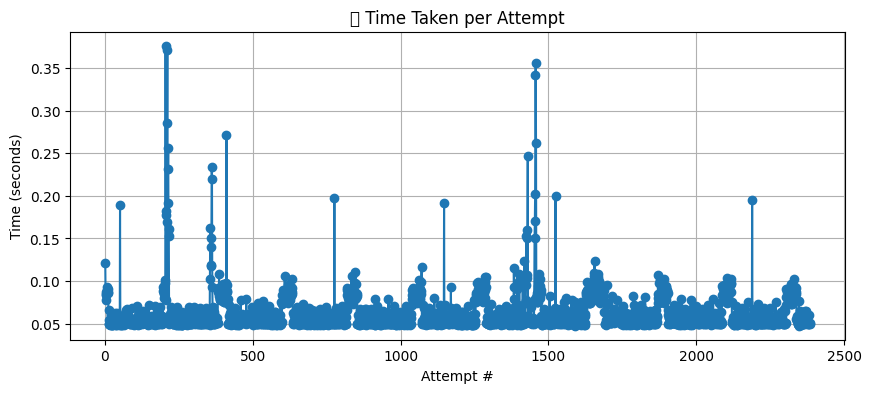

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


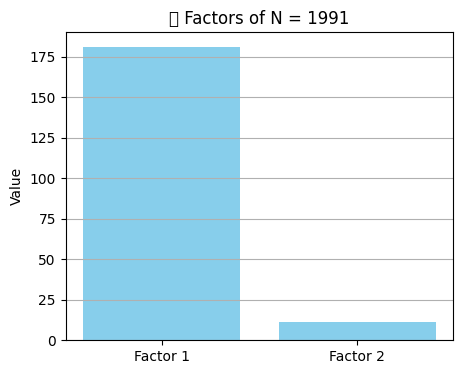

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


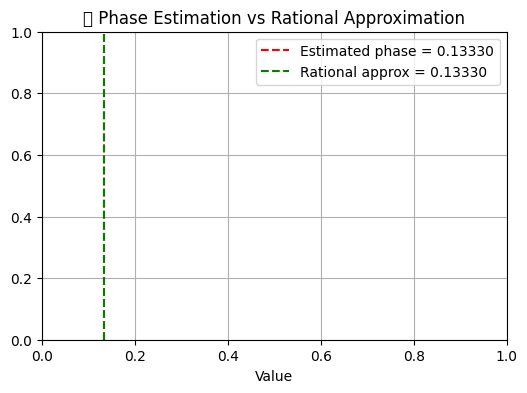

In [ ]:
# ==========================
# 🔓 Quantum RSA Demo using Shor's Algorithm + Visualization
# ==========================
!pip install pennylane matplotlib --quiet

import pennylane as qml
import numpy as np
from fractions import Fraction
from math import gcd
import time
import random
import matplotlib.pyplot as plt

# -------------------------------------
# Utility: Extract factors from period
# -------------------------------------
def get_factors(a, N, r):
    if r % 2 != 0:
        print("⚠️ Period r is odd. Skipping.")
        return None
    plus = pow(a, r // 2) + 1
    minus = pow(a, r // 2) - 1
    f1 = gcd(plus, N)
    f2 = gcd(minus, N)
    print(f"Trying GCD({plus},{N}) = {f1}, GCD({minus},{N}) = {f2}")
    if f1 == 1 or f2 == 1 or f1 == N or f2 == N:
        return None
    return f1, f2

# -------------------------------------
# Simulate Shor's Algorithm
# -------------------------------------
def run_shor_sim(N, a=None, n_count=12):  # 12 qubits for phase estimation
    total_wires = n_count + 6
    dev = qml.device('default.qubit', wires=total_wires, shots=1)

    if a is None:
        while True:
            a = random.randint(2, N - 1)
            if gcd(a, N) == 1:
                break

    def controlled_modular_exponentiation():
        for i in range(n_count):
            exponent = 2 ** i
            angle = (2 * np.pi * pow(a, exponent, N)) / N
            qml.ctrl(qml.RZ, control=i)(angle, wires=n_count)

    @qml.qnode(dev)
    def shor_circuit():
        for i in range(n_count):
            qml.Hadamard(wires=i)
        controlled_modular_exponentiation()
        for i in range(n_count // 2):
            qml.SWAP(wires=[i, n_count - i - 1])
        for j in range(n_count):
            qml.Hadamard(wires=j)
            for k in range(j + 1, n_count):
                angle = -np.pi / (2 ** (k - j))
                qml.ctrl(qml.RZ, control=k)(angle, wires=j)
        return qml.sample(wires=range(n_count))

    start = time.time()
    measurement = shor_circuit()
    bitstring = ''.join(str(b) for b in measurement)
    y = int(bitstring, 2)
    phase = y / (2 ** n_count)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    factors = get_factors(a, N, r)
    elapsed = time.time() - start

    return {
        "a": a,
        "y": y,
        "phase": phase,
        "r": r,
        "factors": factors,
        "elapsed_time": elapsed,
        "bitstring": bitstring
    }

# -------------------------------------
# Run Attempts to Factor N
# -------------------------------------
N = 1991  # Example semi-prime (11 * 181)
max_attempts = 10000
attempt_times = []
success_result = None
start_total = time.time()

for attempt in range(1, max_attempts + 1):
    print(f"\n🔁 Attempt {attempt} to factor N = {N}")
    start_iter = time.time()
    results = run_shor_sim(N)
    iter_time = time.time() - start_iter
    attempt_times.append(iter_time)

    print("Randomly selected a =", results["a"])
    print("Measurement bitstring =", results["bitstring"])
    print("Measured integer y =", results["y"])
    print("Estimated phase = {:.6f}".format(results["phase"]))
    print("Estimated period r =", results["r"])
    print("Elapsed time = {:.4f} seconds".format(results["elapsed_time"]))

    if results["factors"]:
        success_result = results
        break

end_total = time.time()
total_duration = end_total - start_total
average_iter_time = np.mean(attempt_times)

# -------------------------------------
# Summary Output
# -------------------------------------
print("\n===============================")
if success_result:
    print(f"✅ SUCCESS after {attempt} attempts")
    print(f"🔐 N = {N} factored into: {success_result['factors']}")
    print(f"🕒 Total time to find solution: {total_duration:.4f} seconds")
    print(f"⏱️ Average time per attempt: {average_iter_time:.4f} seconds")
    print(f"🧠 Total qubits used: {12 + 6} (Counting: 12, Extra: 6)")
else:
    print("❌ Failed to factor the number after max attempts.")
    print(f"⏱️ Total time: {total_duration:.4f} seconds")
    print(f"⏱️ Average attempt time: {average_iter_time:.4f} seconds")
print("===============================")

# -------------------------------------
# Visualization
# -------------------------------------

# Plot 1: Time per Attempt
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(attempt_times)+1), attempt_times, marker='o')
plt.title("⏱️ Time Taken per Attempt")
plt.xlabel("Attempt #")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

# Plot 2: Factorization Result
if success_result:
    factors = success_result['factors']
    plt.figure(figsize=(5, 4))
    plt.bar(["Factor 1", "Factor 2"], [factors[0], factors[1]], color='skyblue')
    plt.title(f"🔐 Factors of N = {N}")
    plt.ylabel("Value")
    plt.grid(axis='y')
    plt.show()

# Plot 3: Phase vs Rational Approximation
if success_result:
    phase = success_result['phase']
    approx_frac = Fraction(phase).limit_denominator(N)

    plt.figure(figsize=(6, 4))
    plt.axvline(phase, color='red', linestyle='--', label=f"Estimated phase = {phase:.5f}")
    plt.axvline(float(approx_frac), color='green', linestyle='--', label=f"Rational approx = {float(approx_frac):.5f}")
    plt.title("📉 Phase Estimation vs Rational Approximation")
    plt.xlabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


=======

ECC break example

========

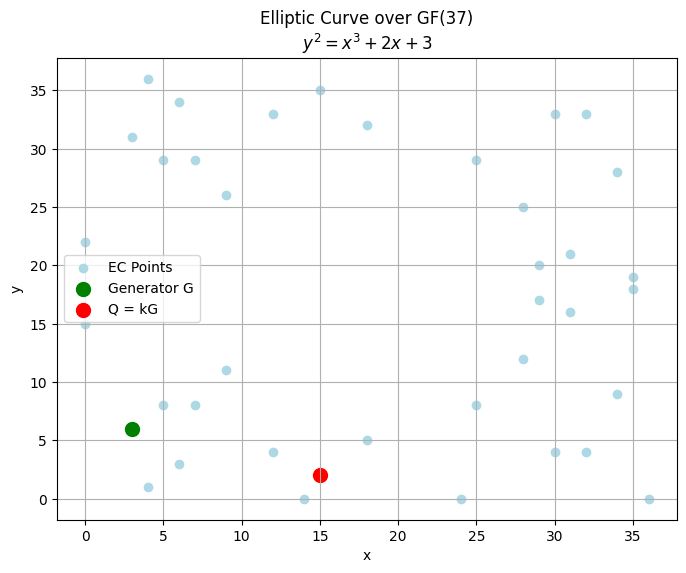

{'Curve': 'y^2 = x^3 + 2x + 3 over GF(37)',
 'Generator G': Point(x=3, y=6),
 'Q = kG': Point(x=15, y=2),
 'Secret k': 7,
 'Recovered k (via brute force / Shor simulation)': 2}

In [ ]:
import matplotlib.pyplot as plt
from collections import namedtuple

# Define a small finite field prime
P = 37  # Small prime for GF(p), suitable for toy ECC

# Define elliptic curve y^2 = x^3 + ax + b over GF(p)
a = 2
b = 3

# Define a point class
Point = namedtuple("Point", "x y")

# Modular inverse
def modinv(k, p):
    return pow(k, -1, p)

# Point addition on elliptic curve
def ecc_add(P1, P2):
    if P1 is None: return P2
    if P2 is None: return P1
    if P1.x == P2.x and (P1.y != P2.y or P1.y == 0):
        return None  # Point at infinity

    if P1 != P2:
        m = (P2.y - P1.y) * modinv(P2.x - P1.x, P) % P
    else:
        m = (3 * P1.x**2 + a) * modinv(2 * P1.y, P) % P

    x3 = (m**2 - P1.x - P2.x) % P
    y3 = (m * (P1.x - x3) - P1.y) % P
    return Point(x3, y3)

# Scalar multiplication
def ecc_mult(k, point):
    result = None
    addend = point
    while k:
        if k & 1:
            result = ecc_add(result, addend)
        addend = ecc_add(addend, addend)
        k >>= 1
    return result

# Generate all points on the curve
def generate_curve_points():
    points = []
    for x in range(P):
        rhs = (x**3 + a*x + b) % P
        for y in range(P):
            if (y*y) % P == rhs:
                points.append(Point(x, y))
    return points

# ECC discrete log demo
curve_points = generate_curve_points()
G = Point(3, 6)  # Generator
k_secret = 7
Q = ecc_mult(k_secret, G)

# Brute-force discrete log (simulate what Shor would do efficiently)
def ecc_discrete_log(G, Q):
    for k in range(1, 100):
        if ecc_mult(k, G) == Q:
            return k
    return None

k_found = ecc_discrete_log(G, Q)

# Visualization
def plot_curve_and_points():
    plt.figure(figsize=(8, 6))
    x_vals = [p.x for p in curve_points]
    y_vals = [p.y for p in curve_points]
    plt.scatter(x_vals, y_vals, color='lightblue', label='EC Points')
    plt.scatter(G.x, G.y, color='green', label='Generator G', s=100)
    plt.scatter(Q.x, Q.y, color='red', label='Q = kG', s=100)

    plt.title("Elliptic Curve over GF({})\n$y^2 = x^3 + {}x + {}$".format(P, a, b))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()

# Results summary
result_summary = {
    "Curve": f"y^2 = x^3 + {a}x + {b} over GF({P})",
    "Generator G": G,
    "Q = kG": Q,
    "Secret k": k_secret,
    "Recovered k (via brute force / Shor simulation)": k_found
}

plot_curve_and_points()
result_summary


In [ ]:
# Install dependencies (uncomment if running for the first time)
# !pip install pennylane numpy matplotlib
import pennylane as qml
import numpy as np
from fractions import Fraction
from math import gcd
import time
import random

In [ ]:
# Utility: Classical post-processing to extract factors from period
def get_factors(a, N, r):
    if r % 2 != 0:
        return None
    plus = pow(a, r // 2) + 1
    minus = pow(a, r // 2) - 1
    f1 = gcd(plus, N)
    f2 = gcd(minus, N)
    if f1 == 1 or f2 == 1 or f1 == N or f2 == N:
        return None
    return f1, f2


In [ ]:
# Simulated Shor's Algorithm for small RSA-like key
def run_shor_sim(N, a=None, n_count=8):
    total_wires = n_count + 6
    dev = qml.device('default.qubit', wires=total_wires, shots=1)

    if a is None:
        while True:
            a = random.randint(2, N-1)
            if gcd(a, N) == 1:
                break

    def controlled_modular_exponentiation():
        for i in range(n_count):
            exponent = 2 ** i
            angle = (2 * np.pi * pow(a, exponent, N)) / N
            qml.ctrl(qml.RZ, control=i)(angle, wires=n_count)

    @qml.qnode(dev)
    def shor_circuit():
        for i in range(n_count):
            qml.Hadamard(wires=i)
        controlled_modular_exponentiation()
        for i in range(n_count // 2):
            qml.SWAP(wires=[i, n_count - i - 1])
        for j in range(n_count):
            qml.Hadamard(wires=j)
            for k in range(j + 1, n_count):
                angle = -np.pi / (2 ** (k - j))
                qml.ctrl(qml.RZ, control=k)(angle, wires=j)
        return qml.sample(wires=range(n_count))

    start = time.time()
    measurement = shor_circuit()
    bitstring = ''.join(str(b) for b in measurement)
    y = int(bitstring, 2)
    phase = y / (2 ** n_count)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    factors = get_factors(a, N, r)
    elapsed = time.time() - start

    return {
        "a": a,
        "y": y,
        "phase": phase,
        "r": r,
        "factors": factors,
        "elapsed_time": elapsed,
        "bitstring": bitstring
    }


In [ ]:
# Define smallest RSA-like number: N = 21 (3 x 7)
N = 21
results = run_shor_sim(N)

# Display results
print("Randomly selected a =", results["a"])
print("Measurement bitstring =", results["bitstring"])
print("Measured integer y =", results["y"])
print("Estimated phase =", results["phase"])
print("Estimated period r =", results["r"])
print("Elapsed time = {:.4f} seconds".format(results["elapsed_time"]))

if results["factors"]:
    print("✅ Success! Factors of", N, "are:", results["factors"])
else:
    print("❌ Failed to find non-trivial factors.")
